In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math
from scipy import signal
from scipy.fft import fft, ifft
import soundfile as sf

In [2]:
# Utility
def splitAndPlot(axis, x, y):
    if len(x) != len(y):
        raise RuntimeError("X and Y plots must match")
    splitLength = int(len(x)/2)
    x1 = np.zeros(splitLength)
    y1 = np.zeros(splitLength)
    x2 = np.zeros(splitLength)
    y2 = np.zeros(splitLength)
    for i in range(splitLength*2):
        if i % 2 == 0:
            x1[int(i/2)] = x[i]
            y1[int(i/2)] = y[i]
        else:
            x2[int(i/2)] = x[i]
            y2[int(i/2)] = y[i]
    axis.scatter(x1, y1)
    axis.scatter(x2, y2)


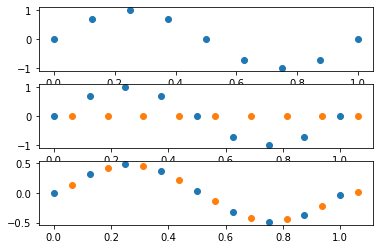

In [3]:
# Upsampling by inserting zeros example

originalNumSamples = 9
L = 2
upsampledNumSamples = originalNumSamples * L

originalT = np.zeros(originalNumSamples)
original = np.zeros(originalNumSamples)
for i in range(originalNumSamples):
    a = float(i)/float(originalNumSamples-1)
    originalT[i] = a
    original[i] = math.sin(2 * math.pi * a)

fig, axs = plt.subplots(3)

axs[0].scatter(originalT, original)

upsampledT = np.zeros(upsampledNumSamples)
upsampled = np.zeros(upsampledNumSamples)
for i in range(upsampledNumSamples):
    a = float(i)/float(upsampledNumSamples-2)
    upsampledT[i] = a
    if (i % 2) == 0:
        upsampled[i] = original[int(i/2)]
splitAndPlot(axs[1], upsampledT, upsampled)

sos = signal.bessel(2, 0.4, btype='lowpass', output='sos')
upsampledFiltered = signal.sosfilt(sos, np.append(upsampled,[0]))[1:]
splitAndPlot(axs[2], upsampledT, upsampledFiltered)

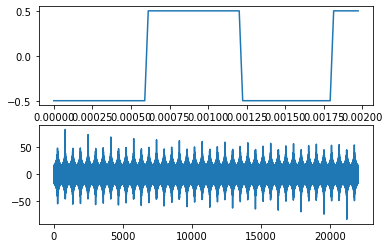

In [4]:
# Comparing naive approach to computing square wave
#   direct vs upsampled

baseSr = 44100

def makeSquareWave(sqFreq, time, amp, inSr):
    numSamples = int(time * inSr)
    deltaPhi = float(sqFreq) / float(inSr)
    phi = 0
    
    tBuf = np.zeros(numSamples)
    buffer = np.zeros(numSamples)
    for i in range(numSamples):
        if phi < 0.5:
            buffer[i] = -1 * amp
        else:
            buffer[i] = amp
        tBuf[i] = float(i) / float(inSr)
        phi += deltaPhi
        while phi >= 1:
            phi -= 1
    return (tBuf, buffer)


t, direct = makeSquareWave(827, 0.002, 0.5, baseSr)
t1, direct1 = makeSquareWave(827, 1, 0.5, baseSr)
directMagDb = 20 * np.log10(np.absolute(fft(direct1)[:int(len(direct1)/2)]))
sf.write('output/directSquare.wav', direct1, baseSr)

fig, axs = plt.subplots(2)
axs[0].plot(t, direct)
axs[1].plot(directMagDb)

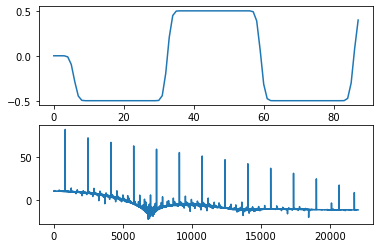

In [5]:
L = 100

sos = signal.bessel(20, ((baseSr/2) - 4000), btype='lowpass', output='sos', fs=baseSr * L)


t, upsampledPre = makeSquareWave(827, 0.002, 0.5, baseSr * L)
upsampledPre = signal.sosfilt(sos, upsampledPre)
finalSamples = int(len(upsampledPre) / L)
upsampledPost = np.zeros(finalSamples)
for i in range(finalSamples):
    upsampledPost[i] = upsampledPre[i * L]

t1, upsampled1Pre = makeSquareWave(827, 1, 0.5, baseSr * L)
upsampled1Pre = signal.sosfilt(sos, upsampled1Pre)
finalSamples = int(len(upsampled1Pre) / L)
upsampled1Post = np.zeros(finalSamples)
for i in range(finalSamples):
    upsampled1Post[i] = upsampled1Pre[i * L]

upsampledMagDb = 20 * np.log10(np.absolute(fft(upsampled1Post)[:int(len(upsampled1Post)/2)]))
sf.write('output/upsampledSquare.wav', upsampled1Post, baseSr)

fig, axs = plt.subplots(2)
axs[0].plot(upsampledPost)
axs[1].plot(upsampledMagDb)